In [ ]:
import os
import glob
import numpy as np
import pandas as pd

import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#ML libraries
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

#DL libraries
import tensorflow as tf
from keras.preprocessing import image
from keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

#Setting a seed
np.random.seed(22)

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/Classroom/2018-19\ :\ ML/Archive.zip

In [ ]:
def get_data(path,label):
    files=np.array(os.listdir(path))

    labels=np.array([label]*len(files))

    images=[]
    for image in files:
        image=cv2.imread(path+image)
        image=cv2.resize(image,dsize=(200,200))
        image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        images.append(image)

    images=np.array(images)

    return images,labels

In [ ]:
normal_images,normal_labels=get_data('/content/train/NORMAL/','normal')
pneumonia_images,pneumonia_labels=get_data('/content/train/PNEUMONIA/','pneumonia')

normal_images_test,normal_labels_test=get_data('/content/test/NORMAL/','normal')
pneumonia_images_test,pneumonia_labels_test=get_data('/content/test/PNEUMONIA/','pneumonia')

In [ ]:
X_train=np.append(normal_images,pneumonia_images,axis=0)
y_train=np.append(normal_labels,pneumonia_labels)

X_test=np.append(normal_images_test,pneumonia_images_test,axis=0)
y_test=np.append(normal_labels_test,pneumonia_labels_test)

print("Image size: ",X_train.shape)
print("Label size: ",y_train.shape)
print("Labels: ",np.unique(y_train))

Image size:  (5216, 200, 200)
Label size:  (5216,)
Labels:  ['normal' 'pneumonia']


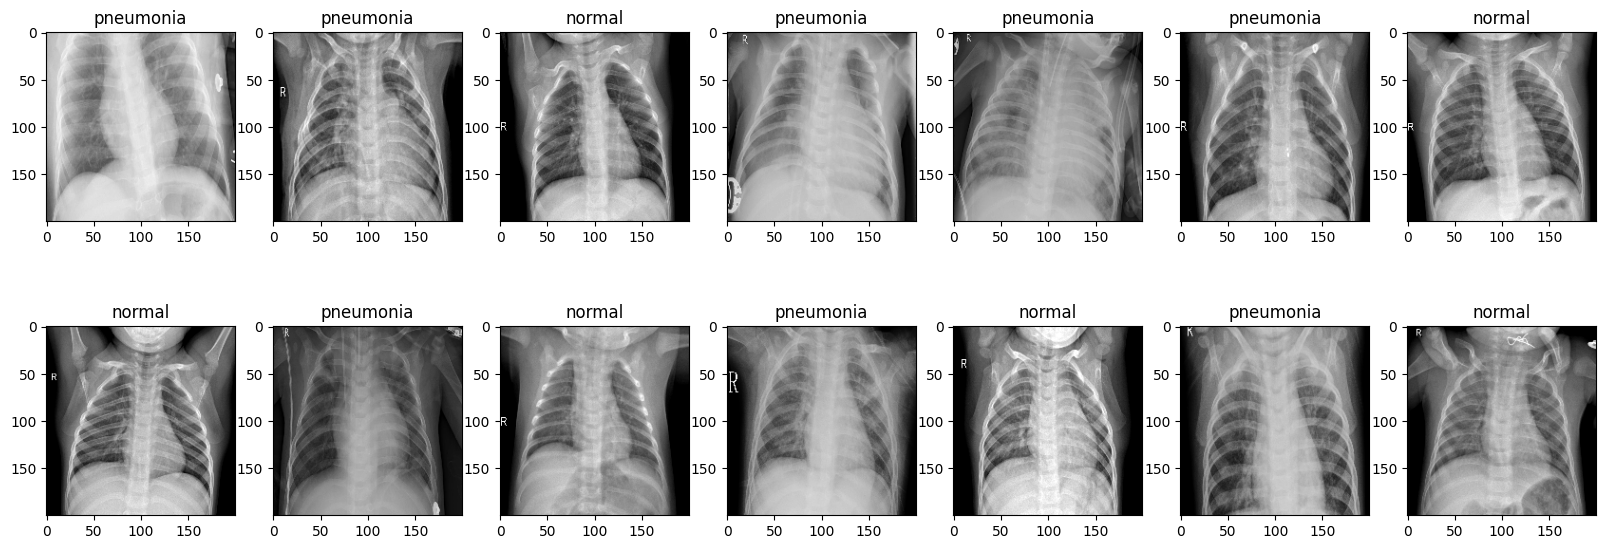

In [ ]:
fig,ax=plt.subplots(ncols=7,nrows=2,figsize=(20,7))

indices=np.random.choice(len(X_train),14)
counter=0

#Displaying subplots of images with labels
for i in range(2):
    for j in range(7):
        ax[i,j].set_title(y_train[indices[counter]])
        ax[i,j].imshow(X_train[indices[counter]],cmap='gray')
        counter+=1

plt.show()

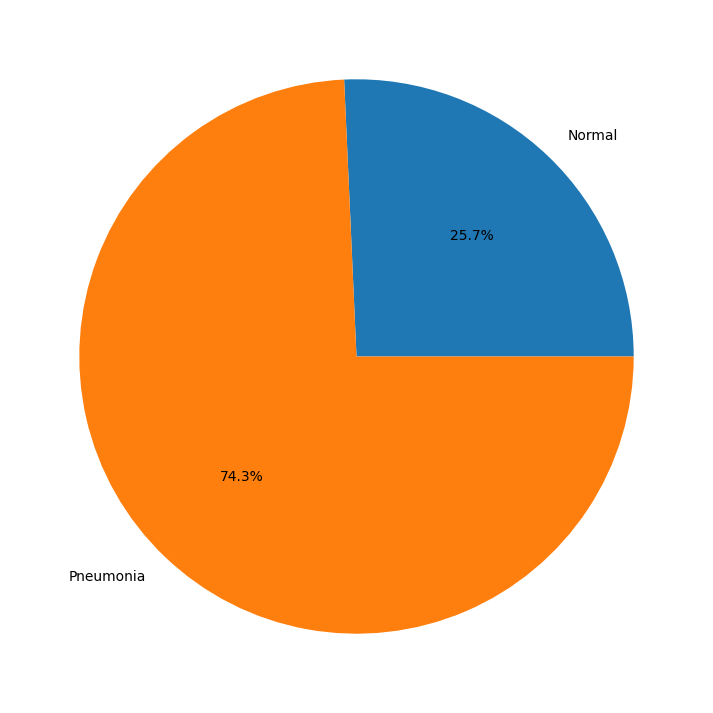

In [ ]:
labels=['Normal','Pneumonia']

targets=[len(normal_images),len(pneumonia_images)]

plt.figure(figsize=(16,9))
plt.pie(x=targets,labels=labels,autopct="%1.1f%%")
plt.show()

In [ ]:
y_train=y_train[:,np.newaxis]
y_test=y_test[:,np.newaxis]

encode=OneHotEncoder(sparse=False)

y_train_encode=encode.fit_transform(y_train)
y_test_encode=encode.transform(y_test)

In [ ]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [ ]:
#Data augumentation
datagen=ImageDataGenerator(
rotation_range=10,
zoom_range=0.1,
width_shift_range=0.1,
height_shift_range=0.1)

datagen.fit(X_train)

#Applying the data augumentation on all training and testing images
traingen=datagen.flow(X_train,y_train_encode,batch_size=32)
testgen=datagen.flow(X_test,y_test_encode,batch_size=32)

In [ ]:
#CNN architecture
model=tf.keras.models.Sequential([
    #Input layer
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(200,200,1)),
    tf.keras.layers.MaxPooling2D(2,2),

    #Hidden layer 1
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    #Hidden layer 2
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    #Hidden layer 3
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    #Flatten layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),

    #Output layer
    tf.keras.layers.Dense(2,activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 198, 198, 16)      160       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 99, 99, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 97, 97, 32)        4640      
                                                                 
 batch_normalization_23 (Ba  (None, 97, 97, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                      

In [ ]:
history=model.fit_generator(traingen,epochs=10,validation_data=(X_test,y_test_encode))

Epoch 1/10
163/163 [==============================] - 17s 86ms/step - loss: 0.3242 - accuracy: 0.8924 - val_loss: 2.4439 - val_accuracy: 0.4167
Epoch 2/10
163/163 [==============================] - 14s 87ms/step - loss: 0.1716 - accuracy: 0.9352 - val_loss: 1.0744 - val_accuracy: 0.6394
Epoch 3/10
163/163 [==============================] - 14s 86ms/step - loss: 0.1459 - accuracy: 0.9427 - val_loss: 1.1429 - val_accuracy: 0.6667
Epoch 4/10
163/163 [==============================] - 14s 86ms/step - loss: 0.1306 - accuracy: 0.9502 - val_loss: 1.4200 - val_accuracy: 0.6506
Epoch 5/10
163/163 [==============================] - 14s 86ms/step - loss: 0.1371 - accuracy: 0.9465 - val_loss: 0.5126 - val_accuracy: 0.8109
Epoch 6/10
163/163 [==============================] - 14s 86ms/step - loss: 0.1147 - accuracy: 0.9565 - val_loss: 0.4320 - val_accuracy: 0.8590
Epoch 7/10
163/163 [==============================] - 14s 85ms/step - loss: 0.1156 - accuracy: 0.9595 - val_loss: 0.4297 - val_accuracy:

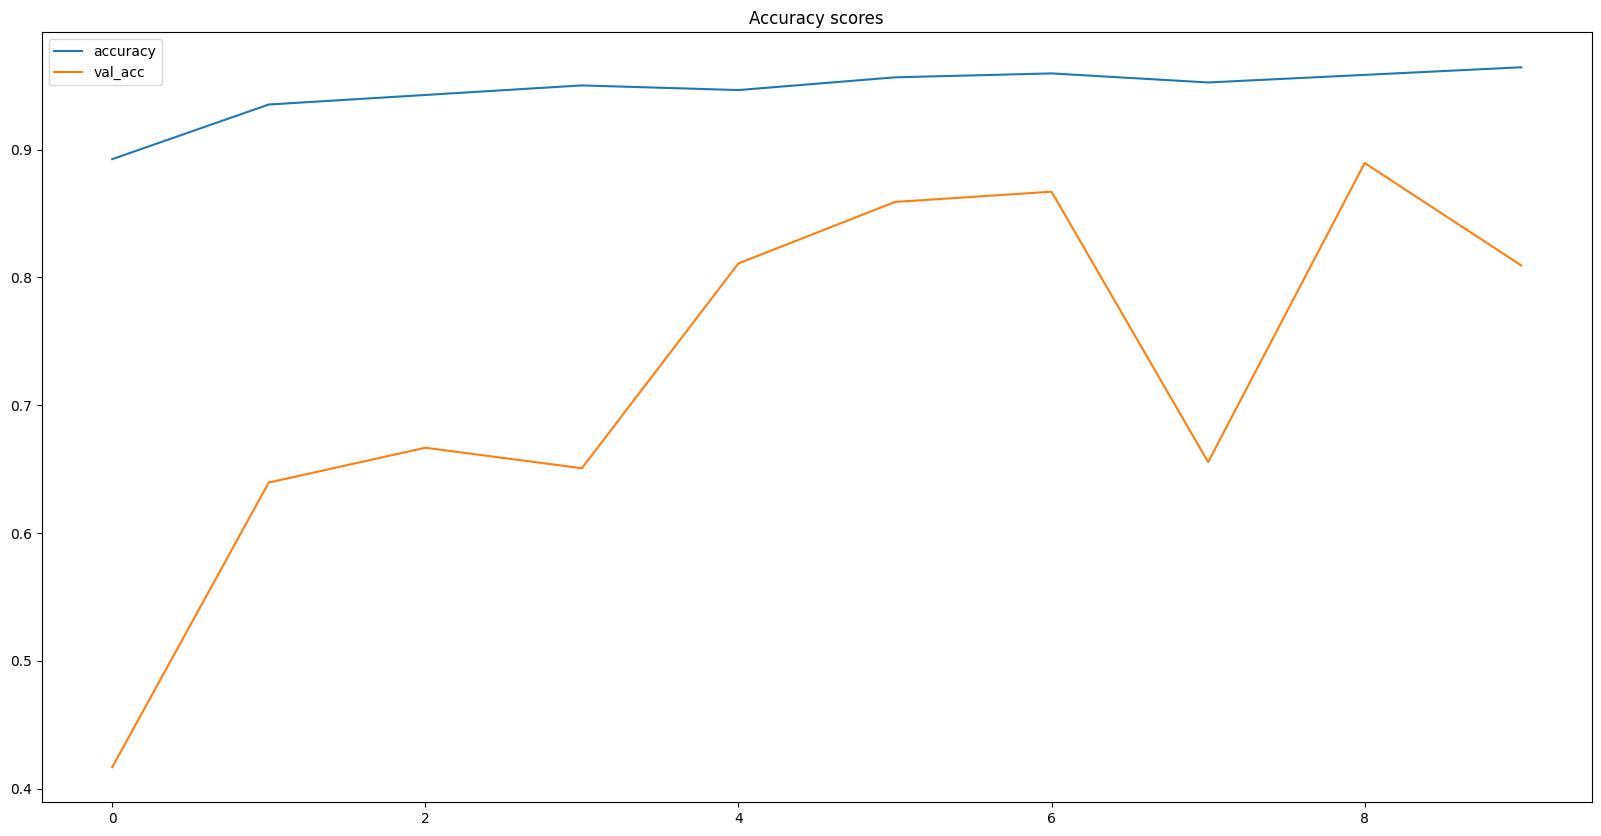

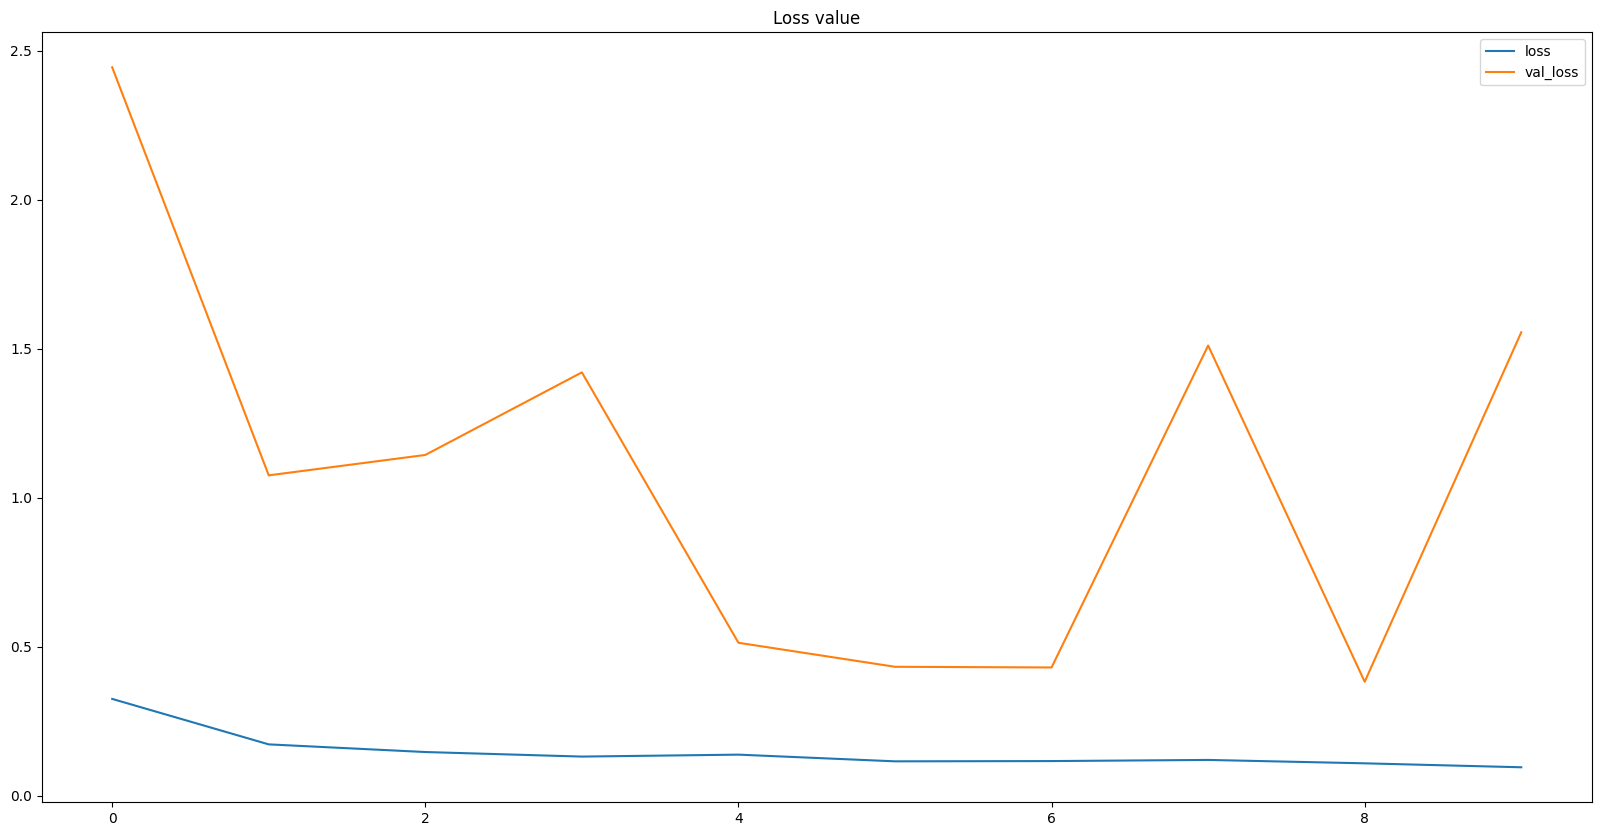

In [ ]:
#Setting up image size
plt.figure(figsize=(20,10))

#Plot train and validation accuracy
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_acc'])
plt.show()

#Plot train and validation loss
plt.figure(figsize=(20,10))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

20/20 [==============================] - 0s 4ms/step


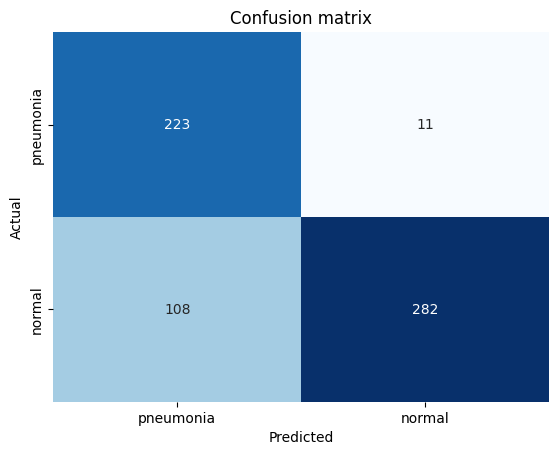

In [ ]:
#predicting the model on test data
predictions=model.predict(X_test)

#Inverse transform the encoded images
predictions=encode.inverse_transform(predictions)

#Creating confusion matrix
cm=confusion_matrix(y_test,predictions)

#Plotting confusion matrix
labels=['pneumonia','normal']
plt.title('Confusion matrix')
sns.heatmap(cm,cbar=False,xticklabels=labels,yticklabels=labels,fmt='d',annot=True,cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#Calculating classification metrics
tn,fp,fn,tp=cm.ravel()
precision=tp/(tp+fp)*100
recall=tp/(tp+fn)*100
F1score=(2*precision*recall/(precision+recall))

print("Precision:",precision)
print("Recall:",recall)
print("F1 score:",F1score)

eval_result=model.evaluate_generator(testgen,624)
print("Accuracy:{}%".format(round(eval_result[1]*100,2)))

Precision: 96.24573378839591
Recall: 72.3076923076923
F1 score: 82.57686676427525
Accuracy:79.97%
